In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re

In [12]:
def extract_slurm_jobs(start_id, end_id, slurm_df, input_size_dict, output_size_dict):
    
    header=["job_id", 
                "job_name", 
                "total_cpu", 
                "ave_rss_mb", 
                "ave_vmz_mb", 
                "alloc_cpu", 
                "alloc_mem_gb", 
                "ave_read_kb", 
                "ave_write_kb", 
                "elapsed_sec", 
                "cpu_effic",
                "cpu_usage",
                "state",  
                "srr_id"]
    fields = ['JobID',
              'JobName',
              'TotalCPU',
              'AveRSS',
              'AveVMSize',
              'AllocTRES',
              'AveDiskRead',
              'AveDiskWrite',
              'Elapsed',
              'State',
              'SubmitLine']
    ext_data = []
    
    for job_id in range(start_id, end_id+1):
        job_id_batch = str(job_id) + ".batch"
        
        #print(fields)
        values=df[fields][df["JobID"]==str(job_id)].values[0]
        values_batch=df[fields][df["JobID"]==job_id_batch].values[0]
        
        #print(len(values), values)
        datum = []
        
        job_id = values[0]
        job_name = values[1]
        

     
        if(len(values_batch[2].split(":")) == 2):
            total_cpu = datetime.strptime(values_batch[2],'%M:%S.%f')
            total_cpu = total_cpu.second + total_cpu.minute*60 + (total_cpu.microsecond / 1000000)
        else:
            total_cpu = datetime.strptime(values_batch[2],'%H:%M:%S')
            total_cpu = total_cpu.second + total_cpu.minute*60 + total_cpu.hour*3600
            
        
        
        ave_rss = values_batch[3]
        if ave_rss == "0":
            ave_rss = float(ave_rss)
        else:
            ave_rss = float(ave_rss[:-1])
        
        ave_vmz = values_batch[4]
        if ave_vmz == "0":
            ave_vmz = float(ave_vmz)
        else:
            ave_vmz = float(ave_vmz[:-1])
        
        alloc_tres = values_batch[5].split(",")
        alloc_cpu = int(alloc_tres[0].split("=")[1])
        alloc_mem = int(alloc_tres[1].split("=")[1][0:-1])
        
        ave_read = values_batch[6]
        if ave_read == "0":
            ave_read = float(ave_read)
        else:
            ave_read = float(ave_read[:-1])
            
        ave_write = values_batch[7]
        if ave_write == "0":
            ave_write = float(ave_write)
        else:
            ave_write = float(ave_write[:-1])
            
        
        
        elapsed = datetime.strptime(values_batch[8],'%H:%M:%S')
        elapsed = elapsed.second + elapsed.minute*60 + elapsed.hour*3600
        
        cpu_effic = (total_cpu / (elapsed * alloc_cpu)) * 100
        cpu_usage = alloc_cpu * (cpu_effic/100)
        
        state = values[9]
        submit_line = values[10].split(" ")
        
        #print(submit_line)
        srr_id = submit_line[-1]
        
        input_size = input_size_dict[srr_id]
        output_size = output_size_dict[srr_id]
        
        datum = [job_id,
                   job_name,
                   total_cpu,
                   ave_rss,
                   ave_vmz,
                   alloc_cpu,
                   alloc_mem,
                   ave_read,
                   ave_write,
                   elapsed,
                   cpu_effic,
                   cpu_usage,
                   state,
                   srr_id]
        
        ext_data.append(datum)

    ext_df = pd.DataFrame(ext_data, columns=header)
    return ext_df

def load_sacct_job_dataframe(path):
    fields = "Account|AdminComment|AllocCPUS|AllocNodes|AllocTRES|AssocID|AveCPU|AveCPUFreq|AveDiskRead|AveDiskWrite|AvePages|AveRSS|AveVMSize|BlockID|Cluster|Comment|Constraints|ConsumedEnergy|ConsumedEnergyRaw|Container|CPUTime|CPUTimeRAW|DBIndex|DerivedExitCode|Elapsed|ElapsedRaw|Eligible|End|ExitCode|Flags|GID|Group|JobID|JobIDRaw|JobName|Layout|MaxDiskRead|MaxDiskReadNode|MaxDiskReadTask|MaxDiskWrite|MaxDiskWriteNode|MaxDiskWriteTask|MaxPages|MaxPagesNode|MaxPagesTask|MaxRSS|MaxRSSNode|MaxRSSTask|MaxVMSize|MaxVMSizeNode|MaxVMSizeTask|McsLabel|MinCPU|MinCPUNode|MinCPUTask|NCPUS|NNodes|NodeList|NTasks|Partition|Priority|QOS|QOSRAW|Reason|ReqCPUFreq|ReqCPUFreqGov|ReqCPUFreqMax|ReqCPUFreqMin|ReqCPUS|ReqMem|ReqNodes|ReqTRES|Reservation|ReservationId|Reserved|ResvCPU|ResvCPURAW|Start|State|Submit|SubmitLine|Suspended|SystemComment|SystemCPU|Timelimit|TimelimitRaw|TotalCPU|TRESUsageInAve|TRESUsageInMax|TRESUsageInMaxNode|TRESUsageInMaxTask|TRESUsageInMin|TRESUsageInMinNode|TRESUsageInMinTask|TRESUsageInTot|TRESUsageOutAve|TRESUsageOutMax|TRESUsageOutMaxNode|TRESUsageOutMaxTask|TRESUsageOutMin|TRESUsageOutMinNode|TRESUsageOutMinTask|TRESUsageOutTot|UID|User|UserCPU|WCKey|WCKeyID|WorkDir"
    fields = fields.split("|")
    df = pd.read_csv(path, sep="|", names=fields)
    return df

def get_file_size_dict(file_path):

    # SIZE IN BYTES
    
    files = open(file_path, "r")

    # reading the file
    data = files.read()

    data_into_list = [i for i in data.split("\n")[1:] if i != '']
    size_dict = dict()
    for data in data_into_list:
        splitted_data = re.split('\s+', data)
        #print(splitted_data)
        size = splitted_data[4]
        srr_id = splitted_data[-1].split(".")[0].split("_")[0]
        
        if srr_id not in size_dict:
            size_dict[srr_id] = [0, 0, 0]
            
        format = splitted_data[-1].split(".")[1]
        if format == "bam":        
            size_dict[srr_id][0] = size
        if format == "bai":
            size_dict[srr_id][1] = size
        if format == "txt":
            size_dict[srr_id][2] = size

    
    files.close()
    return size_dict

def generate_comprehensive_dataframe(path):
    comp_data = []
    stats_df_list = []
    header = ["job_id", "job_name", "alloc_cpu", "alloc_mem_gb", "elapsed_sec", "state", "sra_id", "input_size", "out_bam_size", "out_bai_size", "out_metrics_size"]
    
    input_size_dict = get_file_size_dict(f"{path}/file_size/input_files.txt")
    output_size_dict = get_file_size_dict(f"{path}/file_size/output_files.txt")
    
    sacct_df = load_sacct_job_dataframe(f"{path}/stats/sacct.txt")
    fields = ["JobID", "JobName", "AllocTRES", "Elapsed", "State", "SubmitLine"]
    job_ids = [int(i) for i in sacct_df["JobID"].values if "batch" not in i]
    for job_id in job_ids:
        job_id_batch = str(job_id) + ".batch"
        values=sacct_df[fields][sacct_df["JobID"]==str(job_id)].values[0]
        values_batch=sacct_df[fields][sacct_df["JobID"]==job_id_batch].values[0]

        job_id = int(values[0])
        job_name = values[1]
        
        alloc_tres = values_batch[2].split(",")
        alloc_cpu = int(alloc_tres[0].split("=")[1])
        alloc_mem = int(alloc_tres[1].split("=")[1][0:-1])

        elapsed = datetime.strptime(values_batch[3],'%H:%M:%S')
        elapsed = elapsed.second + elapsed.minute*60 + elapsed.hour*3600

        state = values[4]
        submit_line = values[5].split(" ")
        
        srr_id = submit_line[-1]

        input_size, _, _ = input_size_dict[srr_id]
        bam_size, bai_size, metrics_size = output_size_dict[srr_id]

        
        datum = [job_id,
           job_name,
           alloc_cpu,
           alloc_mem,
           elapsed,
           state,
           srr_id,
           int(input_size),
           int(bam_size),
           int(bai_size),
           int(metrics_size)]
        comp_data.append(datum)
        
        stats_df = load_stat_dataframe_of_job(path, job_id)
     
        if stats_df is not None:
            stats_df_list.append(stats_df)
        
    stats_df = pd.concat(stats_df_list, ignore_index=True, axis=0)
    comp_df = pd.DataFrame(comp_data, columns=header)
    comp_df = pd.merge(comp_df, stats_df, on='job_id', how='outer')
    
    return comp_df
    
def load_stat_dataframe_of_job(dir, job_id):
    from pandas.errors import EmptyDataError 
    
    stats_df = None
    
    try:
        stats_df = pd.read_csv(f"{dir}/stats/{job_id}_stat.csv")
        stats_df = stats_df.astype({"job_id": int, "pid": int, "cpu": float, "vsz_bytes": int, "rss_bytes": int, "read_bytes": int, "write_bytes": int})
    except (FileNotFoundError, EmptyDataError):
        pass
        
        
    return stats_df    

def drop_null_data(df):
    print("SIZE BEFORE DROPPING:", df.shape)
    dfresult = df.dropna()
    print("SIZE BEFORE DROPPING:", dfresult.shape)
    print(f"DROP {df.shape[0] - dfresult.shape[0]} rows") 
    return dfresult

def summarize_dataframe(df):
    df = df.drop(['timestamp'], axis=1)
    header = ["job_id", "job_name", 'alloc_cpu', 'alloc_mem_gb', 'elapsed_sec', 'state', 'sra_id', 'input_size', 'out_bam_size', 'out_bai_size', 'out_metrics_size', 'pid', "n_pack", "pack_id", "ave_cpu", "peak_cpu", "ave_vsz", "peak_vsz", "ave_rss", "peak_rss","read_bytes","write_bytes"]
    sum_data = []
    
    job_ids = df["job_id"].unique()

    for j_id in job_ids:
        stats = df[df["job_id"] == j_id]

        job_id = stats["job_id"].iloc[0]
        job_name = stats["job_name"].iloc[0]
        alloc_cpu = stats["alloc_cpu"].iloc[0]
        alloc_mem = stats["alloc_mem_gb"].iloc[0]
        elapsed_sec = stats["elapsed_sec"].iloc[0]
        state = stats["state"].iloc[0]

        sra_id = stats["sra_id"].iloc[0]
        input_size = stats["input_size"].iloc[0]
        out_bam_size = stats["out_bam_size"].iloc[0]
        out_bai_size = stats["out_bai_size"].iloc[0]
        out_metrics_size = stats["out_metrics_size"].iloc[0]
        pid = stats["pid"].iloc[0]
        n_pack = stats["n_pack"].iloc[0]
        pack_id = stats["pack_id"].iloc[0]
        
        ave_cpu = stats["cpu"].mean()
        peak_cpu = stats["cpu"].max()
        
        ave_vsz = stats["vsz_bytes"].mean()
        peak_vsz = stats["vsz_bytes"].max()

        ave_rss = stats["rss_bytes"].mean()
        peak_rss = stats["rss_bytes"].max()
        
        read = stats["read_bytes"].max()
        write = stats["write_bytes"].max()

        datum = [
            job_id,
            job_name,
            alloc_cpu,
            alloc_mem,
            elapsed_sec,
            state,
            sra_id,
            input_size,
            out_bam_size,
            out_bai_size,
            out_metrics_size,
            pid,
            n_pack,
            pack_id,
            ave_cpu,
            peak_cpu,
            ave_vsz,
            peak_vsz,
            ave_rss,
            peak_rss,
            read,
            write
        ]
        sum_data.append(datum)

    sum_df = pd.DataFrame(sum_data, columns=header)
    
    # df = df.groupby(['job_id', 'job_name', 'alloc_cpu', 'alloc_mem_gb', 'elapsed_sec', 'state', 'threads', 'sra_id', 'input_size', 'output_size', 'pid', "n_pack", "pack_id"]).mean()
    return sum_df

In [13]:
DIR = "./"

In [14]:
comp_df = generate_comprehensive_dataframe(DIR)

In [15]:
comp_df["out_metrics_size"].unique()

array([1713, 1711])

In [16]:
# CHECK NULL DATA
comp_df[comp_df.isna().any(axis=1)]

,job_id,job_name,alloc_cpu,alloc_mem_gb,elapsed_sec,state,sra_id,input_size,out_bam_size,out_bai_size,out_metrics_size,timestamp,pid,n_pack,pack_id,cpu,vsz_bytes,rss_bytes,read_bytes,write_bytes


In [17]:
sum_df = summarize_dataframe(comp_df)

In [18]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_id            2000 non-null   int64  
 1   job_name          2000 non-null   object 
 2   alloc_cpu         2000 non-null   int64  
 3   alloc_mem_gb      2000 non-null   int64  
 4   elapsed_sec       2000 non-null   int64  
 5   state             2000 non-null   object 
 6   sra_id            2000 non-null   object 
 7   input_size        2000 non-null   int64  
 8   out_bam_size      2000 non-null   int64  
 9   out_bai_size      2000 non-null   int64  
 10  out_metrics_size  2000 non-null   int64  
 11  pid               2000 non-null   int64  
 12  n_pack            2000 non-null   int64  
 13  pack_id           2000 non-null   int64  
 14  ave_cpu           2000 non-null   float64
 15  peak_cpu          2000 non-null   float64
 16  ave_vsz           2000 non-null   float64


In [14]:
comp_df["out_metrics_size"]

0        1713
1        1713
2        1713
3        1713
4        1713
         ... 
54085    1711
54086    1711
54087    1711
54088    1711
54089    1711
Name: out_metrics_size, Length: 54090, dtype: int64

## Analysis

In [10]:
completed_df = sum_df[sum_df["state"] == "COMPLETED"]

In [11]:
from scipy.stats.stats import pearsonr

def calculate_correlation(df, features, target):
    
    corr_dict = dict()
    y = df[target]
    for col in features:
        
        x = df[col]
        corr, _ =  pearsonr(x, y)
        corr_dict[col] = corr
    
  
    corr_df = pd.Series(corr_dict)
    corr_df.index = features
    corr_df.sort_values(ascending=False).plot.bar(figsize=(20, 8))
    sorted_corr_dict = dict(sorted(corr_dict.items(), key=lambda x:np.abs(x[1]), reverse=True))
    
    return sorted_corr_dict


/tmp/ipykernel_1092019/616510216.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


{'out_bam_size': 0.9225796179967511,
 'input_size': 0.9223250632792681,
 'ave_cpu': -0.47951287918864416,
 'out_metrics_size': 0.47423776825751096,
 'out_bai_size': 0.3991609336290647,
 'write_bytes': 0.243526125865749,
 'ave_rss': 0.18175596729705187,
 'peak_rss': 0.17514543603636148,
 'alloc_cpu': -0.15648865566085662,
 'alloc_mem_gb': 0.13191515592629605,
 'read_bytes': 0.11022701325025977,
 'n_pack': 0.09524535954710776,
 'ave_vsz': 0.09037849019667103,
 'peak_vsz': 0.08760684361109292,
 'peak_cpu': 0.0462497105588233}

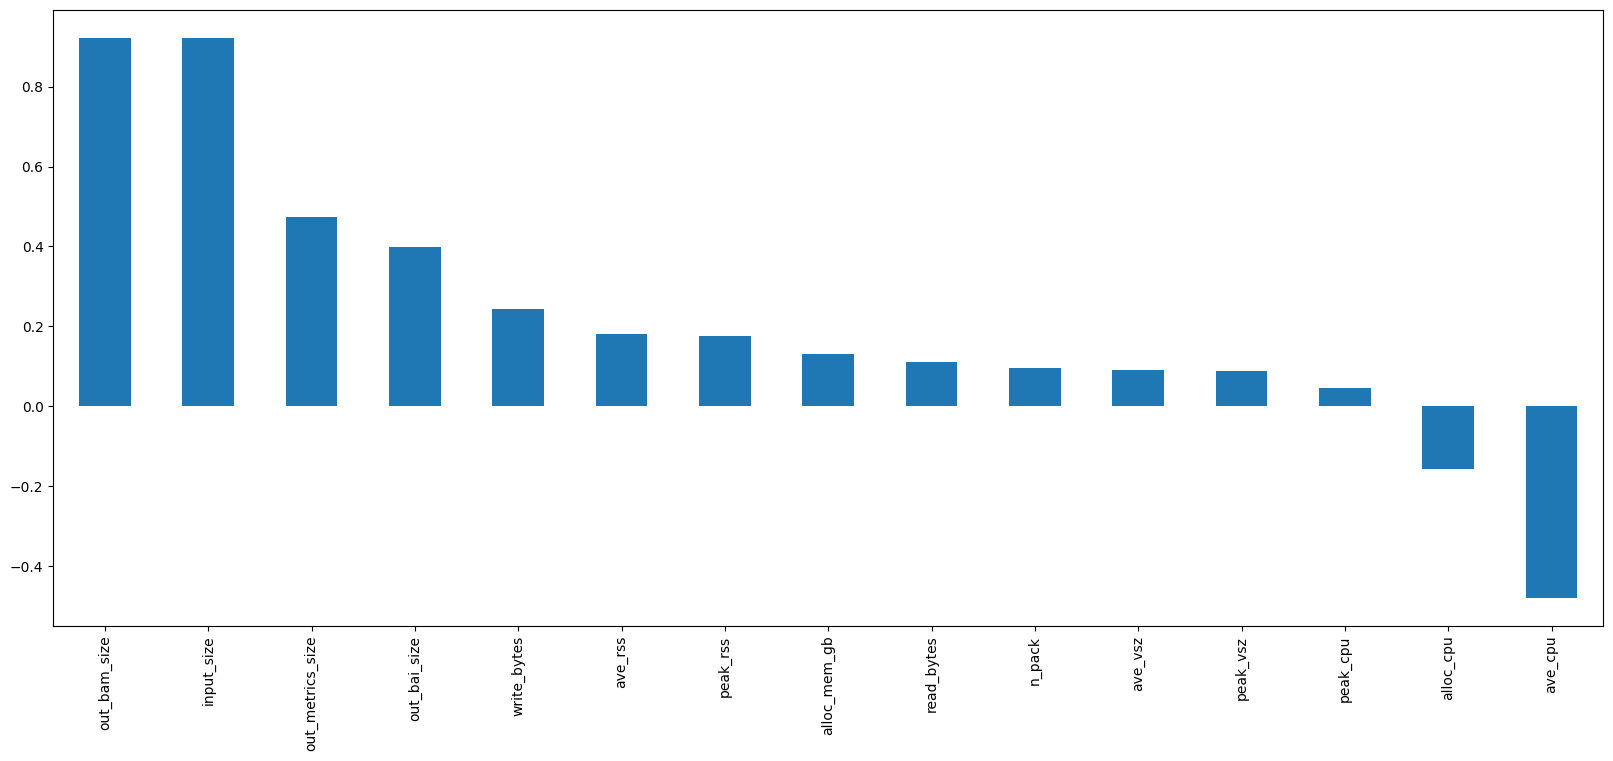

In [12]:
features =  ["alloc_cpu", "alloc_mem_gb", "input_size", "out_bam_size", "out_bai_size", "out_metrics_size", "n_pack", "ave_cpu", "peak_cpu", "ave_vsz", "peak_vsz", "ave_rss", "peak_rss", "read_bytes", "write_bytes"]
target = "elapsed_sec"
calculate_correlation(sum_df, features, target)

### Pre-execution Features

Text(0.5, 0.0, 'Number of Allocated CPU')

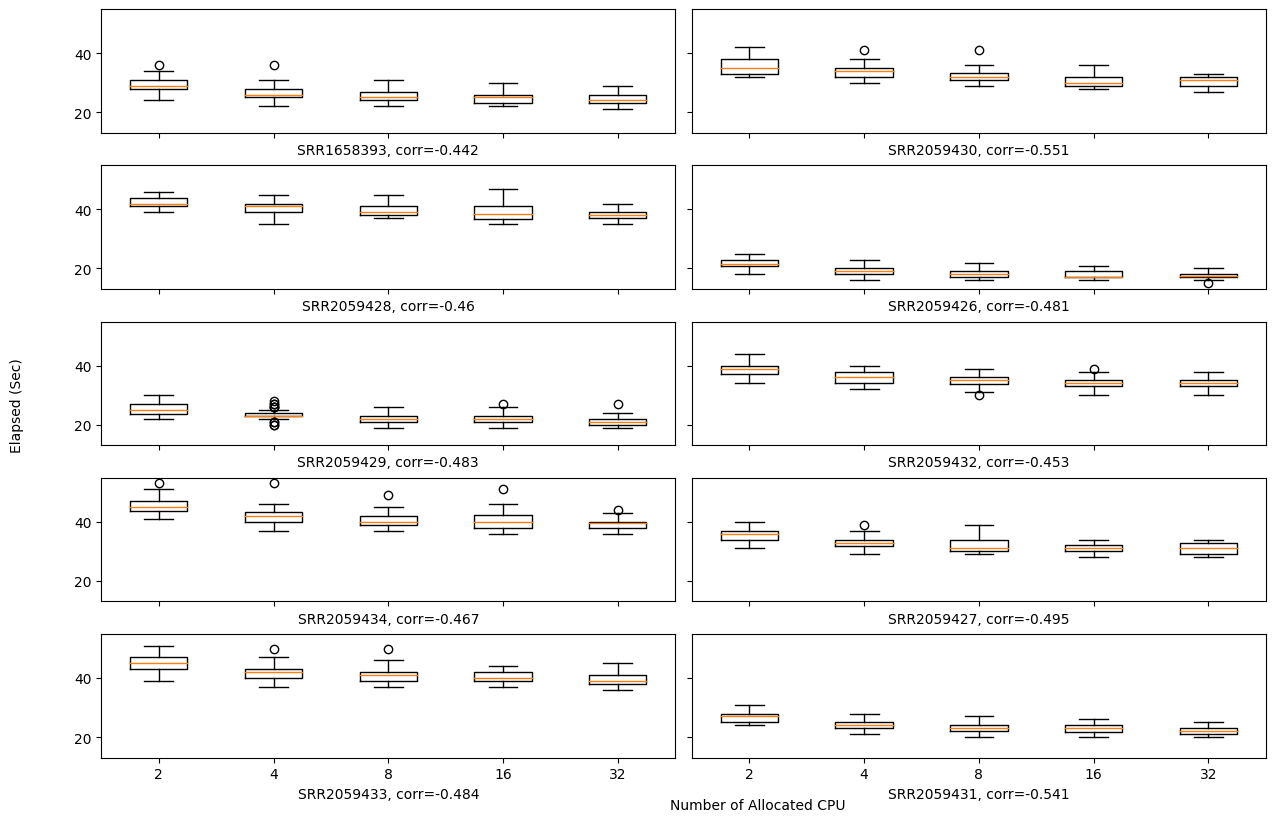

In [13]:
target = "alloc_cpu"
sra_ids = completed_df["sra_id"].unique()
target_unique = sorted(completed_df[target].unique())
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    data = dict()
    
    for n_target in target_unique:
        data[str(n_target)] = filtered_df[filtered_df[target] == n_target]["elapsed_sec"]

    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].boxplot(data.values())
    ax[i%5][int(i/(n/2))].set_xticks(np.arange(1, len(target_unique)+1), target_unique)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")

fig.text(-0.05, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Number of Allocated CPU', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Number of Allocated Memory (GB)')

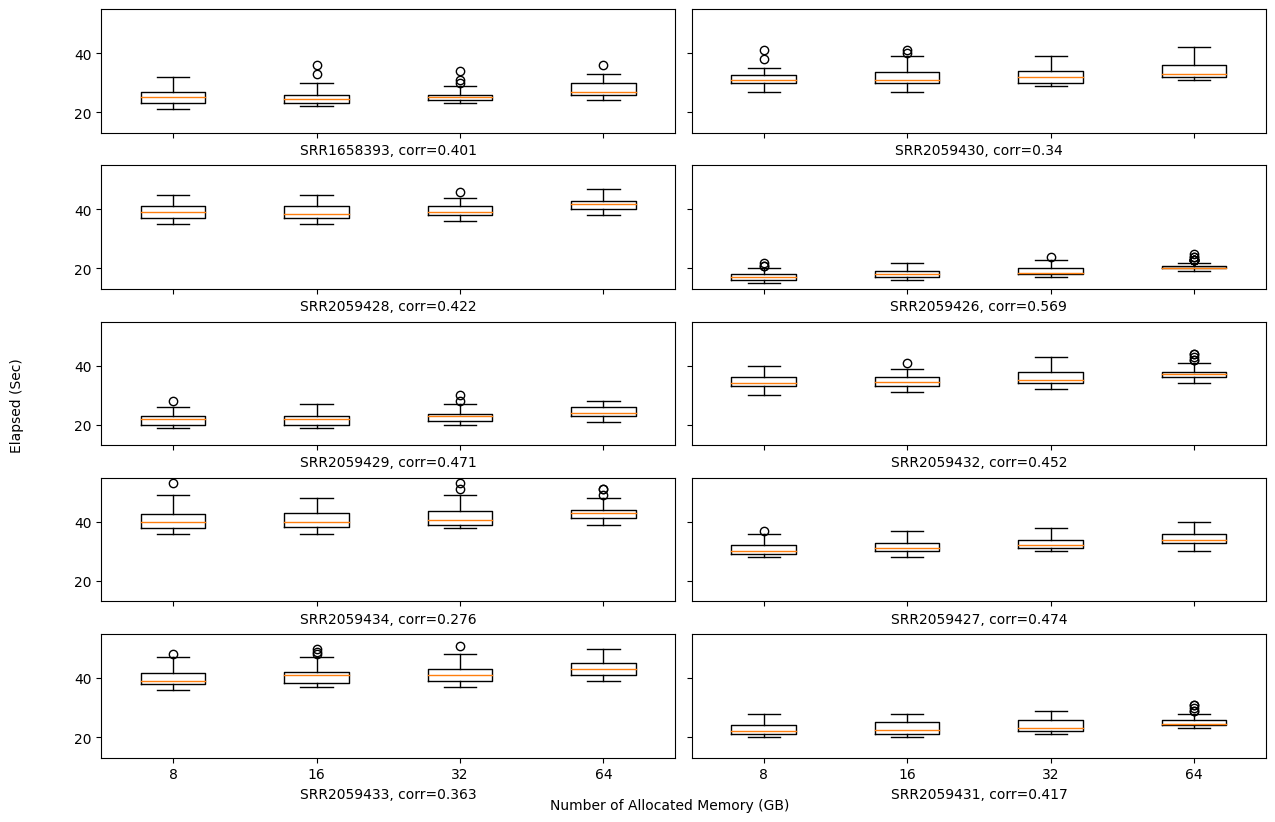

In [14]:
target = "alloc_mem_gb"
sra_ids = completed_df["sra_id"].unique()
target_unique = sorted(completed_df[target].unique())
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    data = dict()
    
    for n_target in target_unique:
        data[str(n_target)] = filtered_df[filtered_df[target] == n_target]["elapsed_sec"]

    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].boxplot(data.values())
    ax[i%5][int(i/(n/2))].set_xticks(np.arange(1, len(target_unique)+1), target_unique)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")

fig.text(-0.05, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Number of Allocated Memory (GB)', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

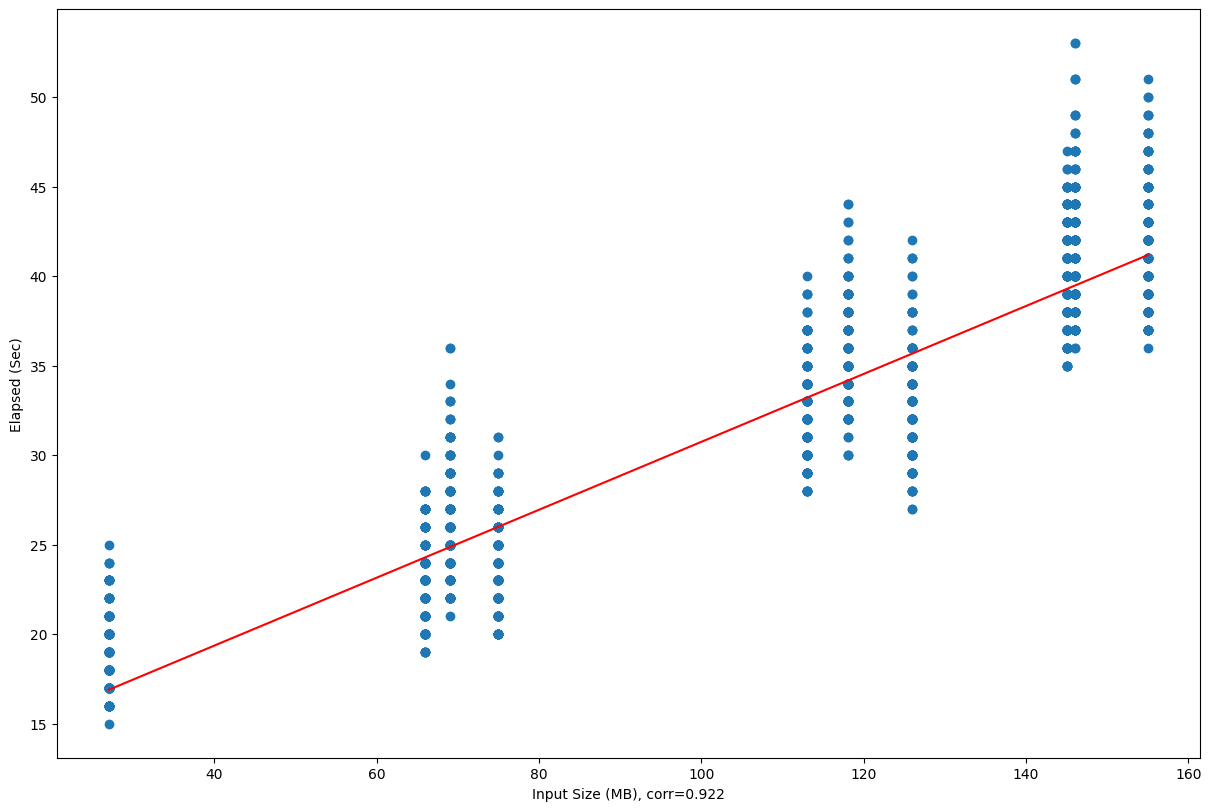

In [15]:
target = "input_size"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2) # B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Input Size (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

## Post-exec Features

Text(0.5, 0.0, 'Average CPU Usage (%)')

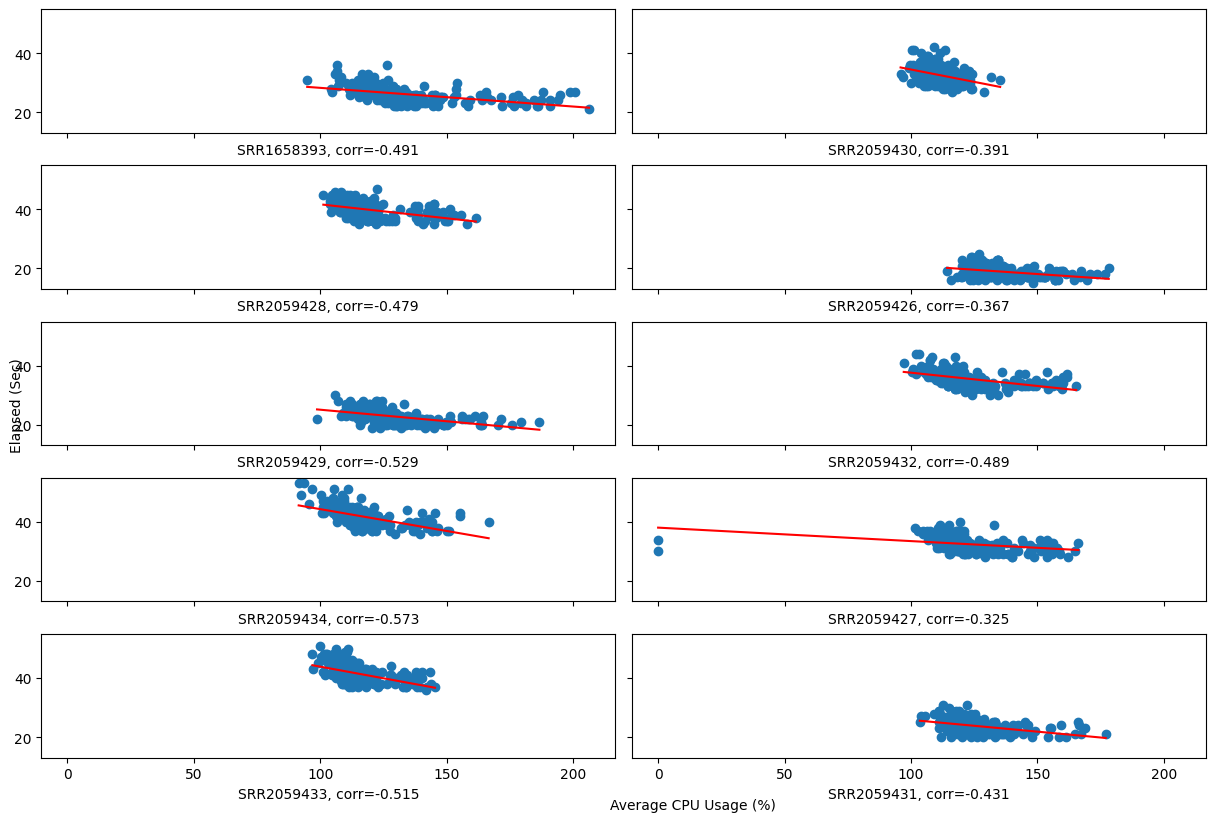

In [16]:
target = "ave_cpu"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Average CPU Usage (%)', va='center', rotation='horizontal')

Text(0.5, 0.0, 'Peak CPU Usage (%)')

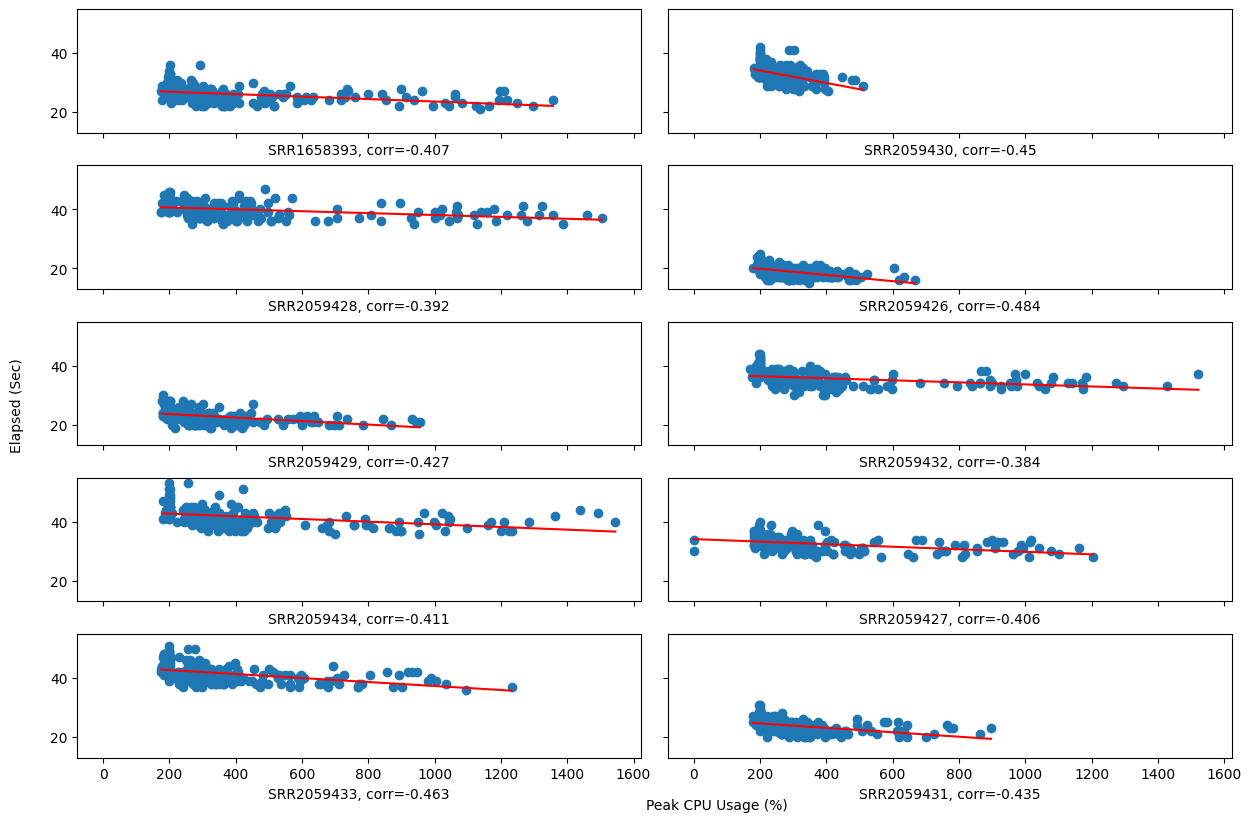

In [17]:
target = "peak_cpu"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target]
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.5, 0.0, 'Peak CPU Usage (%)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Average Physical Memory Usage (MB)')

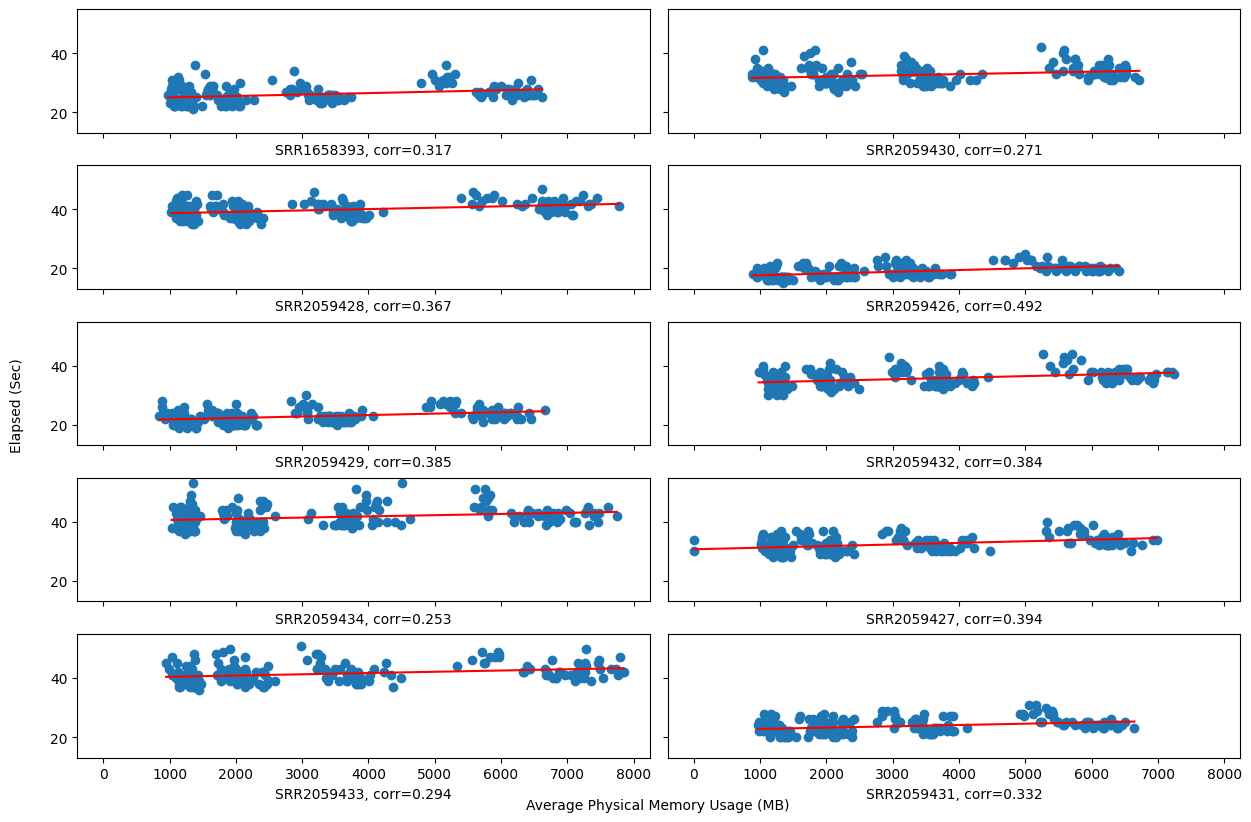

In [19]:
target = "ave_rss"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024**2) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Average Physical Memory Usage (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Peak Physical Memory Usage (MB)')

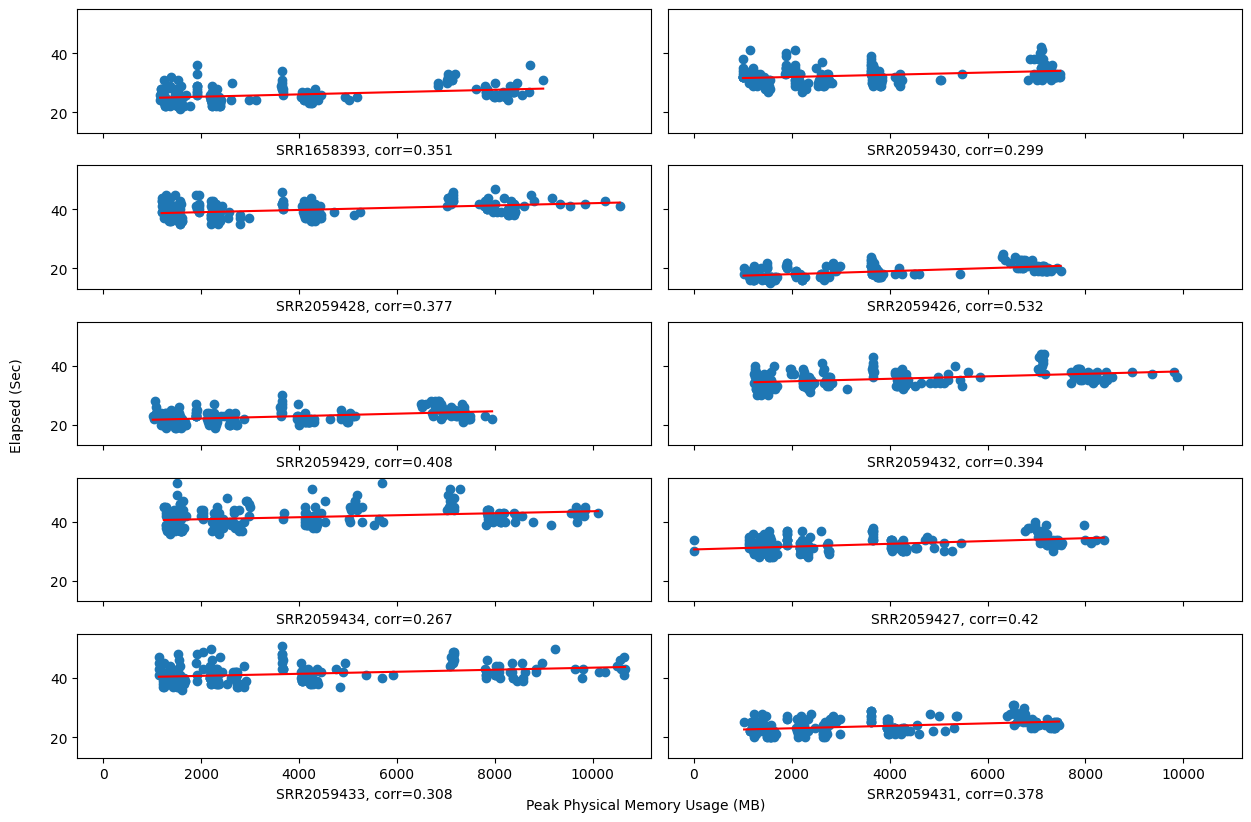

In [20]:
target = "peak_rss"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024**2) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Peak Physical Memory Usage (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Average Virtual Memory Size (MB)')

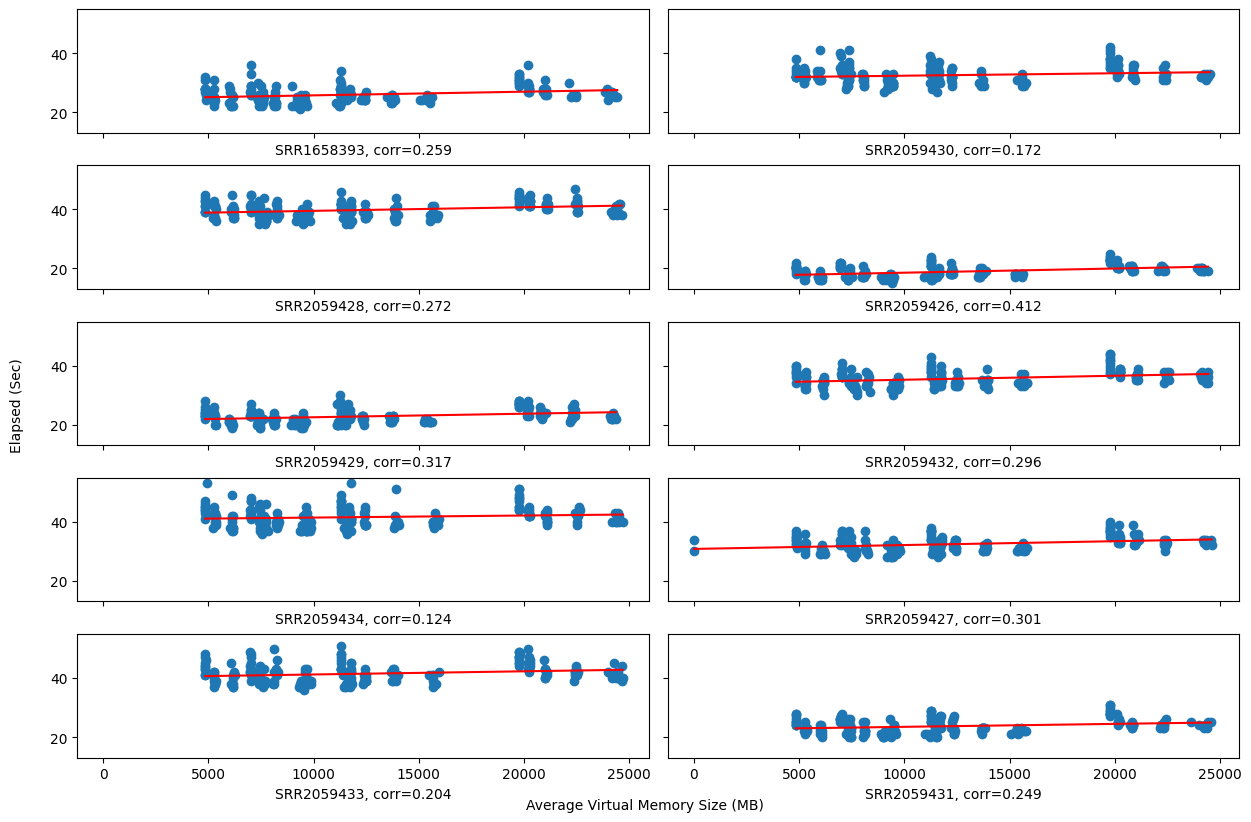

In [21]:
target = "ave_vsz"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024**2) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Average Virtual Memory Size (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Peak Virtual Memory Size (MB)')

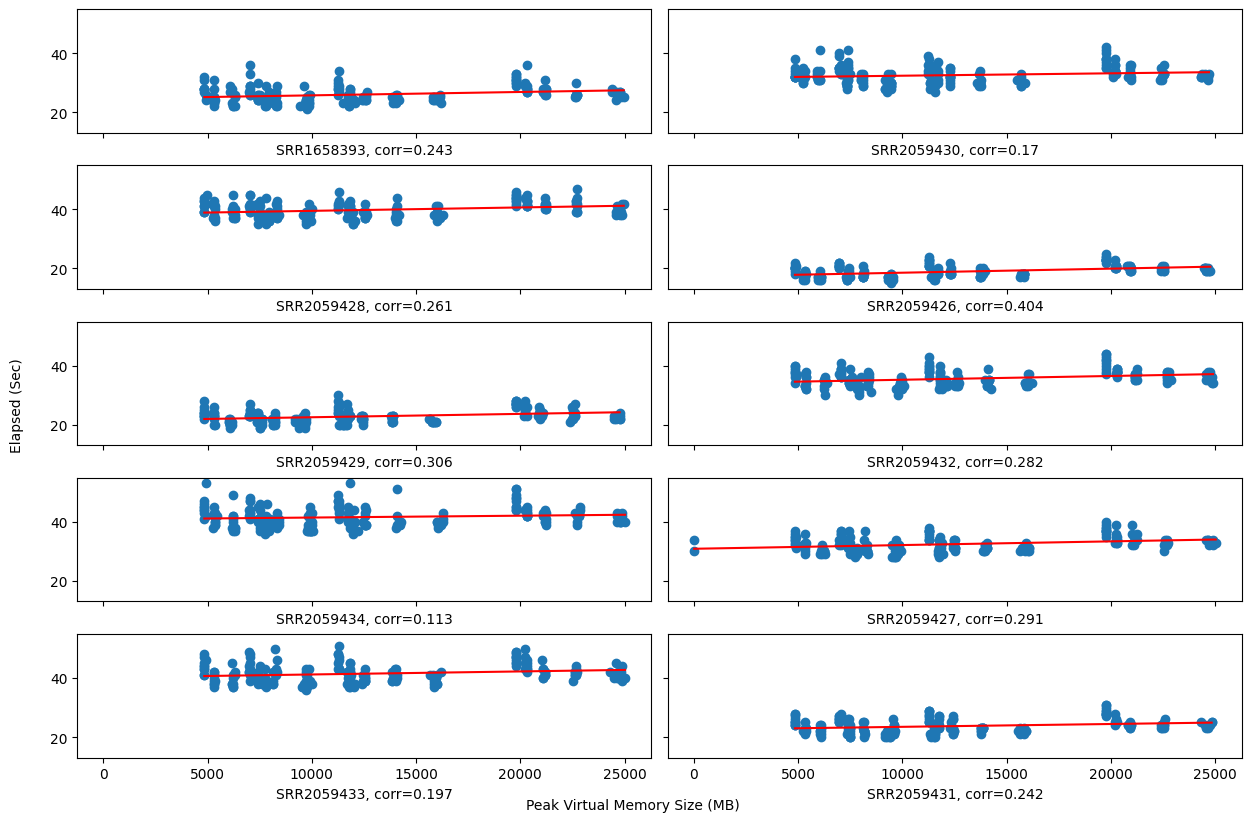

In [22]:
target = "peak_vsz"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] / (1024**2) # B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Peak Virtual Memory Size (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Write Operations (MB)')

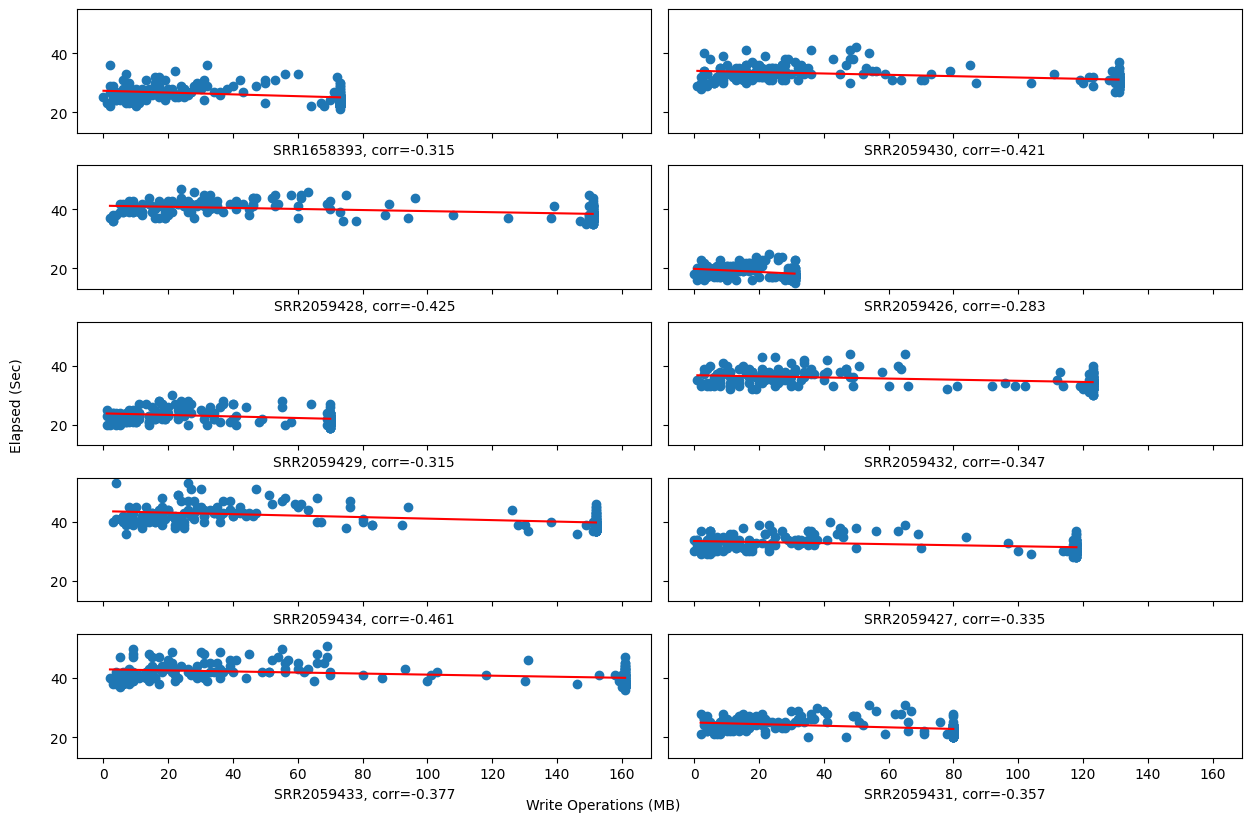

In [23]:
target = "write_bytes"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] // (1024**2)# B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
    
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Write Operations (MB)', va='center', rotation='horizontal')

Text(0.4, 0.0, 'Read Operations (MB)')

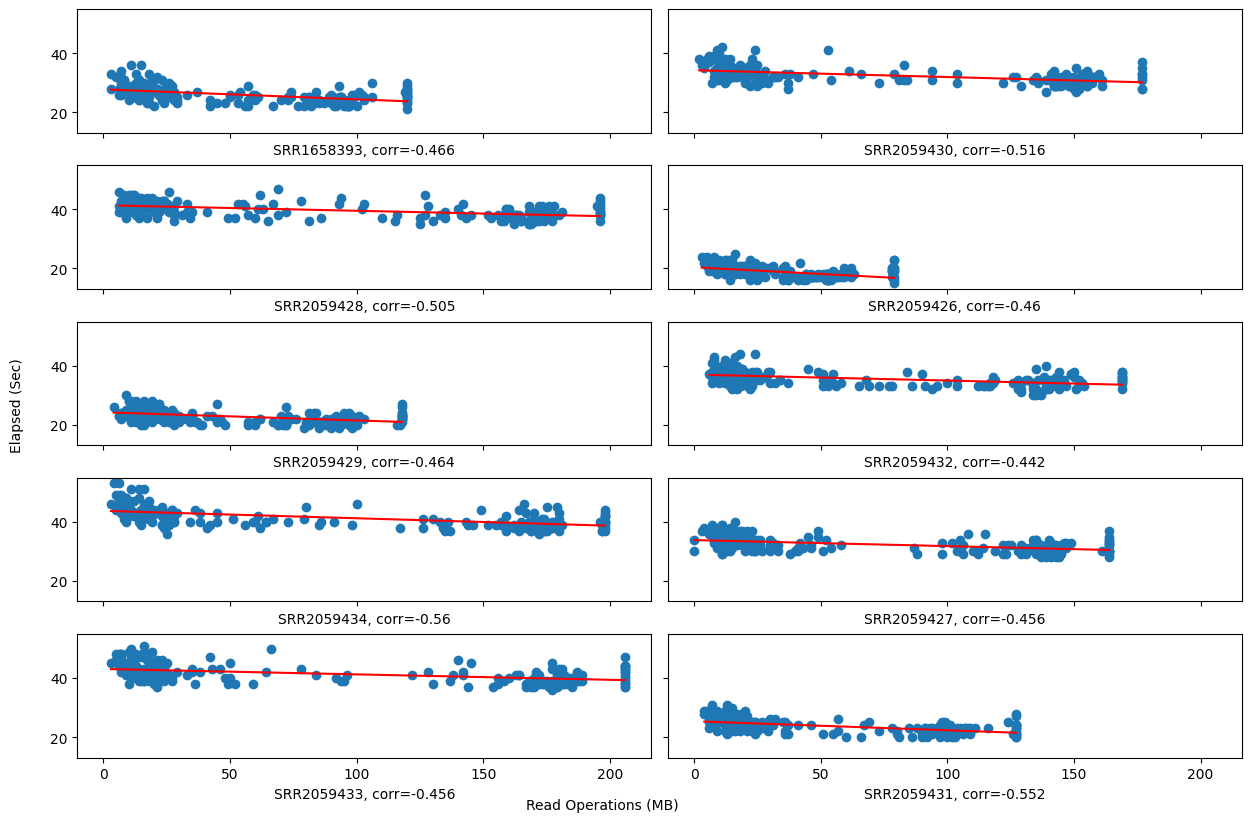

In [24]:
target = "read_bytes"
sra_ids = completed_df["sra_id"].unique()
n = len(sra_ids)
fig, ax = plt.subplots(int(n/2), 2, figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

for i in range(n):
    s_id = sra_ids[i]
    filtered_df = completed_df[completed_df["sra_id"] == s_id]
    x = filtered_df[target] // (1024**2)# B to KB
    y = filtered_df["elapsed_sec"]
    
    ax[i%5][int(i/(n/2))].scatter(x, y)
    ax[i%5][int(i/(n/2))].plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
    corr, _ =  pearsonr(x, y)
    ax[i%5][int(i/(n/2))].set_xlabel(f"{sra_ids[i]}, corr={round(corr,3)}")
    
fig.text(-0.03, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
fig.text(0.4, 0.0, 'Read Operations (MB)', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

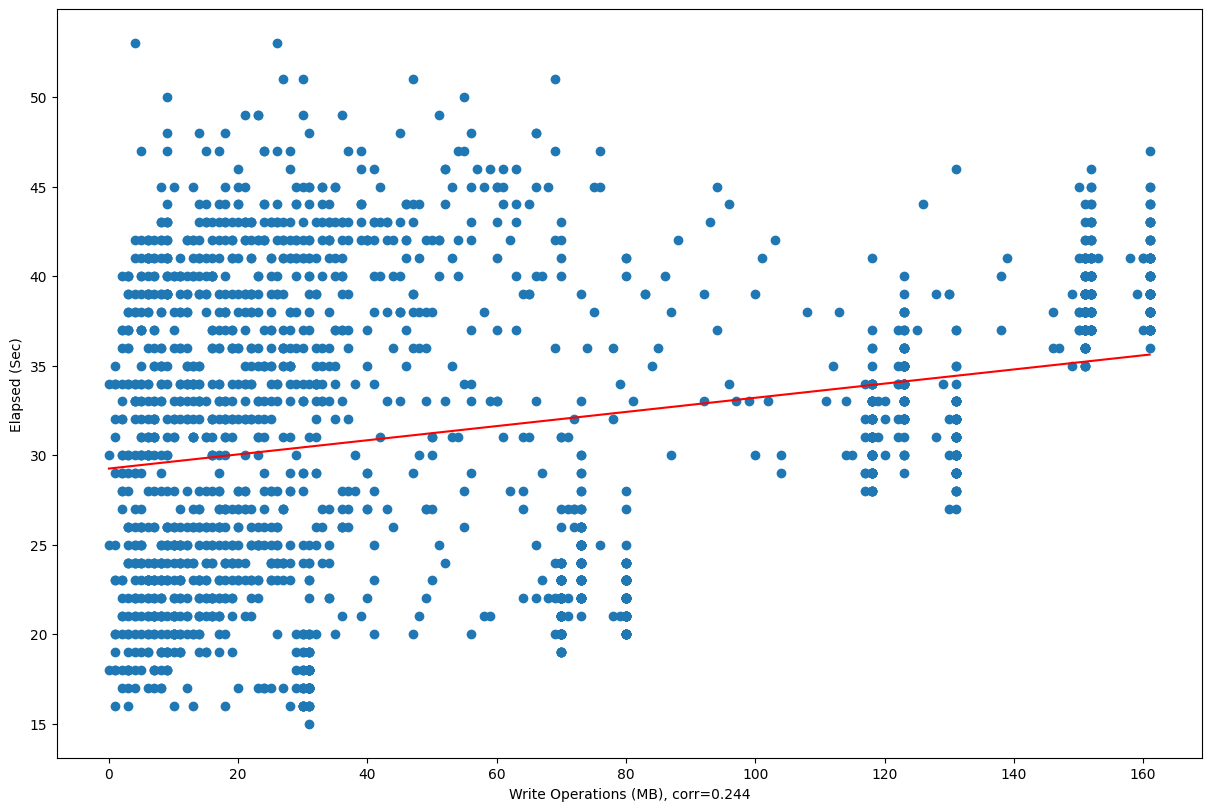

In [25]:
target = "write_bytes"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2) # B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Write Operations (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

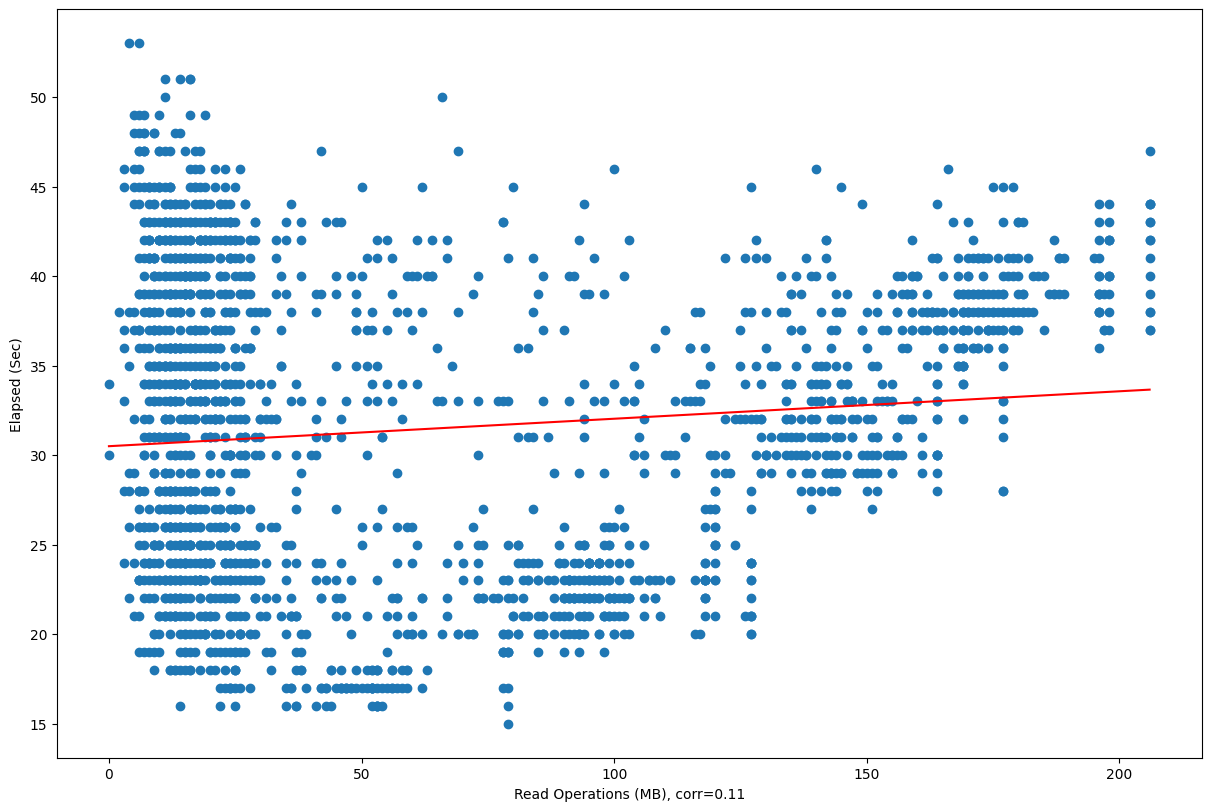

In [26]:
target = "read_bytes"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2) # B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Read Operations (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

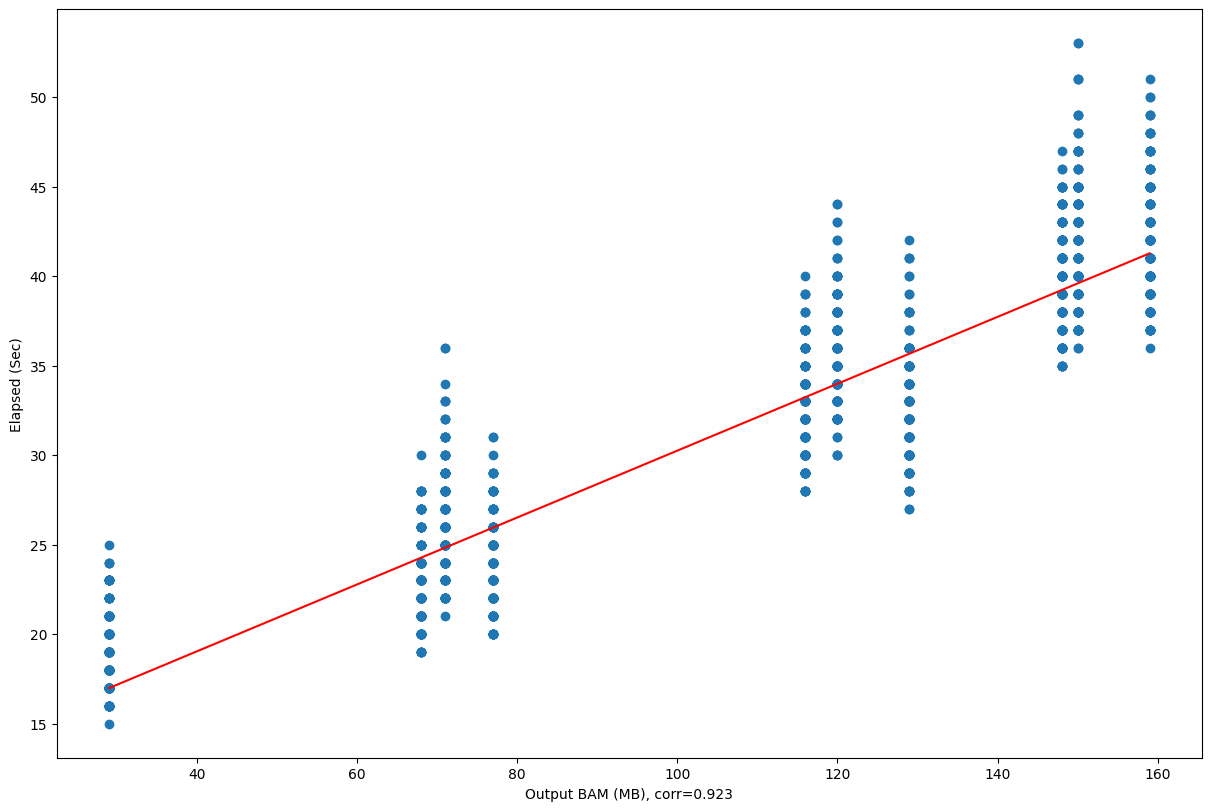

In [27]:
target = "out_bam_size"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024**2)# B to MB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Output BAM (MB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

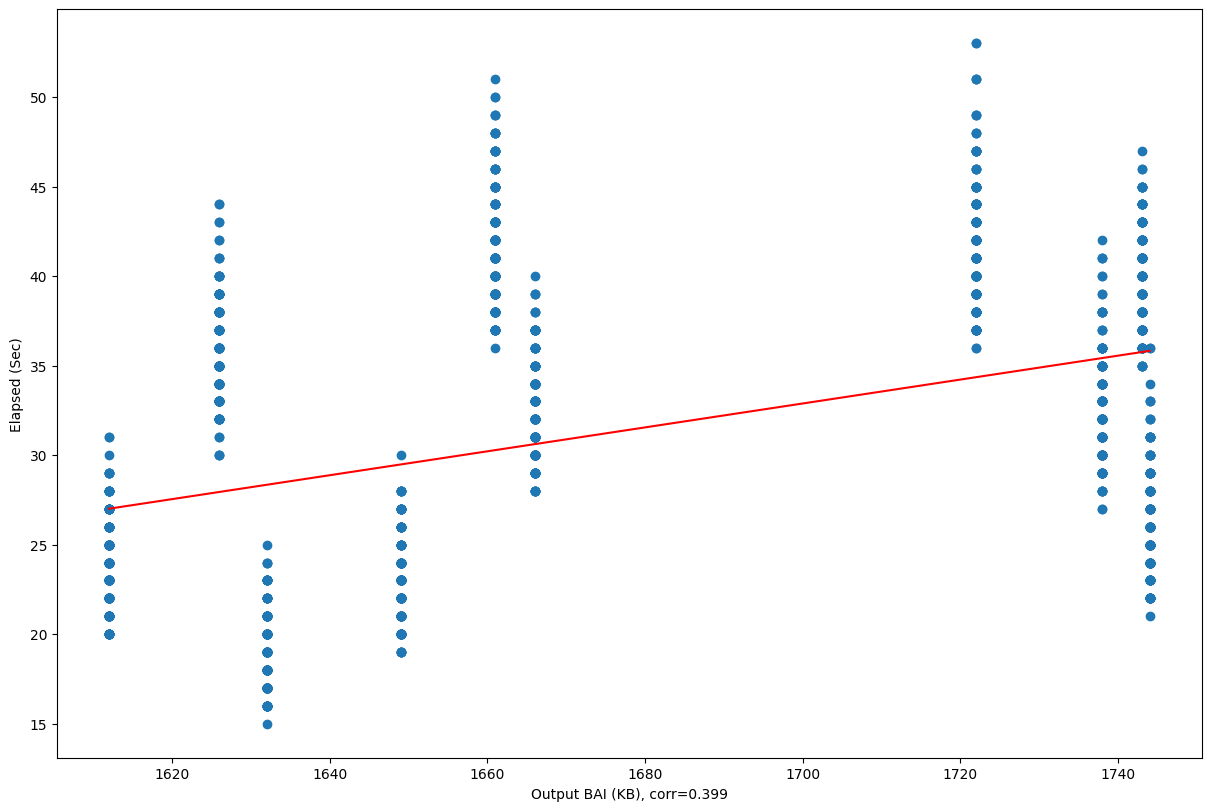

In [28]:
target = "out_bai_size"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] // (1024) # B to KB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Output BAI (KB), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

Text(0, 0.5, 'Elapsed (Sec)')

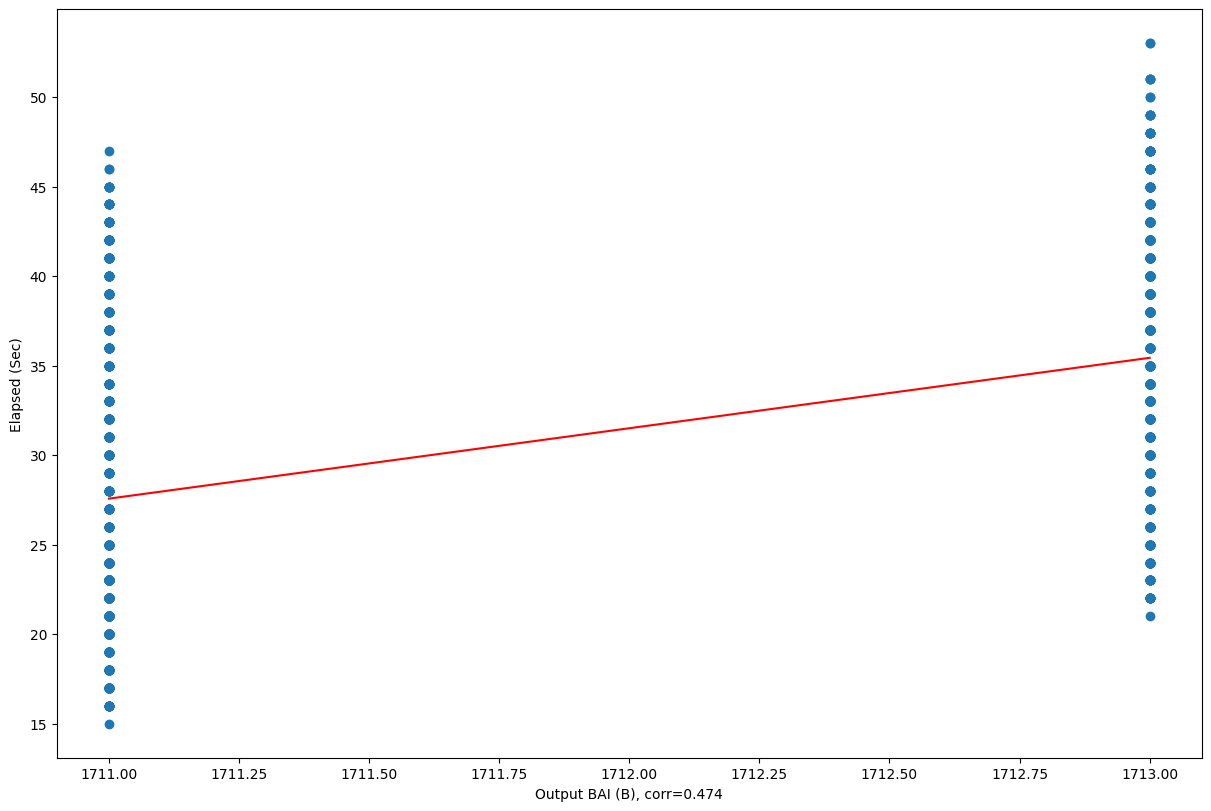

In [30]:
target = "out_metrics_size"


fig, ax = plt.subplots(figsize=(12, 8), sharey=True,sharex=True,constrained_layout = True)

x = completed_df[target] # B to KB
y = completed_df["elapsed_sec"]

ax.scatter(x, y)
ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
     (np.unique(x)), color='red')
corr, _ =  pearsonr(x, y)
ax.set_xlabel(f"Output BAI (B), corr={round(corr,3)}")
ax.set_ylabel("Elapsed (Sec)")
# fig.text(0.0, 0.5, 'Elapsed (Sec)', va='center', rotation='vertical')
# fig.text(0.5, 0.0, 'Input Size', va='center', rotation='horizontal')

## Machine Learning

In [19]:
from scipy.stats.stats import pearsonr
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [23]:
def calculate_correlation(df, features, target):
    
    corr_dict = dict()
    y = df[target]
    for col in features:
        
        x = df[col]
        corr, _ =  pearsonr(x, y)
        corr_dict[col] = corr
    
  
    corr_df = pd.Series(corr_dict)
    corr_df.index = features
    sorted_corr_dict = dict(sorted(corr_dict.items(), key=lambda x:np.abs(x[1]), reverse=True))
    
    return sorted_corr_dict

def split_train_test(df, test_prop=0.25):
    separator_index = int(df.shape[0] * (1-test_prop))
    np.random.seed(42)
    df = df.sample(frac = 1)
    train_data, test_data = df.iloc[:separator_index], df.iloc[separator_index:]
    return train_data, test_data
    
def fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo):
    model = None
    score = -1
    
    if algo == "linear_regression":
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = metrics.mean_absolute_error(y_test, y_pred)
    if algo == "random_forest":
        model = RandomForestRegressor(n_estimators = 1000)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = metrics.mean_absolute_error(y_test, y_pred)
    
    
    return model, score

def get_k_of_best_model(models_dict):
    best_score = np.inf
    best_k = -1
    
    for k in models_dict:
        model = models_dict[k][0]
        score = models_dict[k][1]
        if score < best_score:
            best_score = score
            best_k = k
    return best_k


def get_best_pos_models(train_data, test_data, pre_features, pos_features, algo):
    df = pd.concat([train_data, test_data], ignore_index=False, axis=0)
    best_pos_models_dict = dict()
    for pos in pos_features:
        pos_corr_dict = calculate_correlation(df, pre_features, pos)
        sorted_pos_features = [feature for feature in pos_corr_dict]
        for i in range(len(sorted_pos_features)):
            k = i+1
            best_k_pos_features = sorted_pos_features[:k]
            
            X_train = train_data[best_k_pos_features].values
            y_train = train_data[pos].values
            X_test = test_data[best_k_pos_features].values
            y_test = test_data[pos].values
            
            model, score = fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo)

            if pos not in best_pos_models_dict or score < best_pos_models_dict[pos][2]:
                best_pos_models_dict[pos] = [model, best_k_pos_features, score]

                
    return best_pos_models_dict

def build_two_stage(df, algo):
    
    pre_features = ['alloc_cpu', 
                    'alloc_mem_gb', 
                    'input_size',
                   'n_pack']
    
    pos_features = ['out_bam_size',
                    'out_bai_size',
                    'out_metrics_size',
                    'ave_cpu', 
                    'peak_cpu',
                    'ave_vsz',
                    'peak_vsz',
                    'ave_rss',
                    'peak_rss',
                    'read_bytes',
                    'write_bytes']
    features = pre_features + pos_features
    

    train_data, test_data = split_train_test(df, 0.25)
    
    elapsed_corr_dict = calculate_correlation(df, features, 'elapsed_sec')
    
    # FEATURES FOR PREDICTING ELAPSED TIME
    sorted_elapsed_features = [feature for feature in elapsed_corr_dict]
    
#     pre_elapsed_features = [feature for feature in sorted_elapsed_features if feature in pre_features]
    
#     post_elapsed_features = [feature for feature in sorted_elapsed_featues if feature in post_features]
    
    best_pos_models_dict = get_best_pos_models(train_data, test_data, pre_features, pos_features, algo)
    
    elapsed_models_dict = dict()
    
    for i in range(len(sorted_elapsed_features)):
        k = i+1
        best_k_elapsed_features = sorted_elapsed_features[:k]

#         best_k_elapsed_pre_features = [feature for feature in best_k_elapsed_features if feature in pre_features]
#         best_k_elapsed_pos_features = [feature for feature in best_k_elapsed_features if feature in pos_features]
        
        for pos in pos_features:
            pos_model = best_pos_models_dict[pos][0]
            pos_pre_features = best_pos_models_dict[pos][1]
            
            X_train = train_data[pos_pre_features].values
            X_test = test_data[pos_pre_features].values
            
            train_data.loc[:, pos] = pos_model.predict(X_train)
            test_data.loc[:, pos] = pos_model.predict(X_test)
            
        
        X_train = train_data[best_k_elapsed_features].values
        y_train = train_data['elapsed_sec'].values
        X_test = test_data[best_k_elapsed_features].values
        y_test = test_data['elapsed_sec'].values
        
        elapsed_model, elapsed_score = fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo)
        
        elapsed_models_dict[k] = [elapsed_model, elapsed_score]
        
    k_of_best_model = get_k_of_best_model(elapsed_models_dict)
    best_model = elapsed_models_dict[k_of_best_model][0]
    
    #print(elapsed_models_dict)
    #return elapsed_models_dict, best_pos_models_dict, best_k_elapsed_features
    return best_model, best_pos_models_dict, sorted_elapsed_features[:k_of_best_model]

def build_single_stage(df, algo):
    pre_features = ['alloc_cpu', 
                    'alloc_mem_gb',  
                    'input_size',
                   'n_pack']
    
    pos_features = ['out_bam_size',
                    'out_bai_size',
                    'out_metrics_size',
                    'ave_cpu', 
                    'peak_cpu',
                    'ave_vsz',
                    'peak_vsz',
                    'ave_rss',
                    'peak_rss',
                    'read_bytes',
                    'write_bytes']
    
    train_data, test_data = split_train_test(df, 0.25)
    
    features = pre_features + pos_features
    
    corr_dict = calculate_correlation(df, features, 'elapsed_sec')
    
    sorted_elapsed_features = [feature for feature in corr_dict if feature in pre_features]
    
    elapsed_models_dict = dict()
    
    for i in range(len(sorted_elapsed_features)):
        k = i+1
        best_k_elapsed_features = sorted_elapsed_features[:k]
        
        X_train = train_data[best_k_elapsed_features].values
        y_train = train_data['elapsed_sec'].values
        X_test = test_data[best_k_elapsed_features].values
        y_test = test_data['elapsed_sec'].values
        
        elapsed_model, elapsed_score = fit_and_evaluate_model(X_train, y_train, X_test, y_test, algo)
        
        elapsed_models_dict[k] = [elapsed_model, elapsed_score]
    
    k_of_best_model = get_k_of_best_model(elapsed_models_dict)
    best_model = elapsed_models_dict[k_of_best_model][0]
    
    return best_model, sorted_elapsed_features[:k_of_best_model]

In [24]:
completed_df = sum_df[sum_df["state"] == "COMPLETED"]
completed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   job_id            2000 non-null   int64  
 1   job_name          2000 non-null   object 
 2   alloc_cpu         2000 non-null   int64  
 3   alloc_mem_gb      2000 non-null   int64  
 4   elapsed_sec       2000 non-null   int64  
 5   state             2000 non-null   object 
 6   sra_id            2000 non-null   object 
 7   input_size        2000 non-null   int64  
 8   out_bam_size      2000 non-null   int64  
 9   out_bai_size      2000 non-null   int64  
 10  out_metrics_size  2000 non-null   int64  
 11  pid               2000 non-null   int64  
 12  n_pack            2000 non-null   int64  
 13  pack_id           2000 non-null   int64  
 14  ave_cpu           2000 non-null   float64
 15  peak_cpu          2000 non-null   float64
 16  ave_vsz           2000 non-null   float64


In [25]:
lr_single_stage_elapsed_model, lr_single_stage_features = build_single_stage(completed_df, "linear_regression")

In [26]:
rf_single_stage_elapsed_model, rf_single_stage_features = build_single_stage(completed_df, "random_forest")

In [27]:
lr_second_stage_elapsed_model, lr_first_stage_models, lr_second_stage_features = build_two_stage(completed_df, 'linear_regression')

In [28]:
rf_second_stage_elapsed_model, rf_first_stage_models, rf_second_stage_features = build_two_stage(completed_df, 'random_forest')

In [29]:
def absolute_error(actual, calculated):
    n = len(actual)
    result = np.zeros(n)
    for i in range(n):
        result[i] = abs(actual[i]-calculated[i])
    return result

def error(actual, calculated):
    n = len(actual)
    result = np.zeros(n)
    for i in range(n):
        result[i] = calculated[i]-actual[i]
    return result


In [30]:
def evaluate_single_model(model, features, target, df, metrics):
    train_data, test_data = split_train_test(df, 0.25)
    X_test = test_data[features].values
    y_test = test_data[target].values
    y_pred = model.predict(X_test)
    scores = None
    if metrics == 'absolute_error':
        scores = absolute_error(y_test, y_pred)
    if metrics == 'squared_error':
        scores = squared_error(y_test, y_pred)
    if metrics == 'error':
        scores = error(y_test, y_pred)
    return scores

def evaluate_two_stage_model(first_stage_models, second_stage_model, features, target, df, metrics):
    train_data, test_data = split_train_test(df, 0.25)
    
    pos_features = ['out_bam_size',
                    'out_bai_size',
                    'out_metrics_size',
                    'ave_cpu', 
                    'peak_cpu',
                    'ave_vsz',
                    'peak_vsz',
                    'ave_rss',
                    'peak_rss',
                    'read_bytes',
                    'write_bytes']

    
    for feature in features:
        if feature in pos_features:
            first_stage_model = first_stage_models[feature][0]
            pre_features = first_stage_models[feature][1]
            test_data.loc[:, feature] = first_stage_model.predict(test_data[pre_features].values)    
    
    X_test = test_data[features].values
    y_test = test_data[target].values
    
    y_pred = second_stage_model.predict(X_test)
    
    scores = None
    if metrics == 'absolute_error':
        scores = absolute_error(y_test, y_pred)
    if metrics == 'squared_error':
        scores = squared_error(y_test, y_pred)
    if metrics == 'error':
        scores = error(y_test, y_pred)
    return scores
    

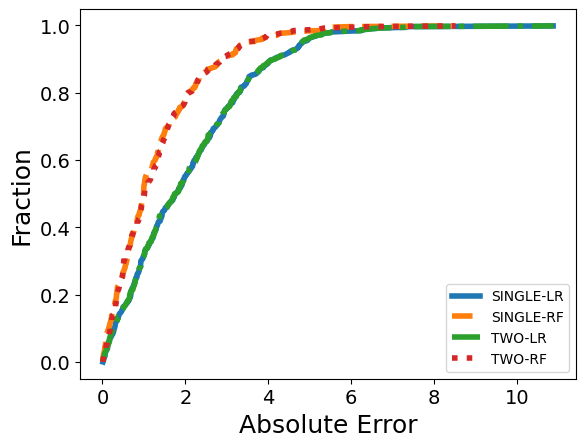

In [31]:
completed_df = sum_df[sum_df["state"] == "COMPLETED"]

lr_single_ae = evaluate_single_model(lr_single_stage_elapsed_model, lr_single_stage_features, 'elapsed_sec', completed_df, 'absolute_error')
rf_single_ae = evaluate_single_model(rf_single_stage_elapsed_model, rf_single_stage_features, 'elapsed_sec', completed_df, 'absolute_error')
lr_two_ae = evaluate_two_stage_model(lr_first_stage_models, lr_second_stage_elapsed_model, lr_second_stage_features, 'elapsed_sec', completed_df, 'absolute_error')
rf_two_ae = evaluate_two_stage_model(rf_first_stage_models, rf_second_stage_elapsed_model, rf_second_stage_features, 'elapsed_sec', completed_df, 'absolute_error')


sorted_lr_single_ae = np.sort(lr_single_ae)
frac_lr_single_ae = np.arange(len(lr_single_ae)) / len(lr_single_ae)

sorted_rf_single_ae = np.sort(rf_single_ae)
frac_rf_single_ae = np.arange(len(rf_single_ae)) / len(rf_single_ae)

sorted_lr_two_ae = np.sort(lr_two_ae)
frac_lr_two_ae = np.arange(len(lr_two_ae)) / len(lr_two_ae)

sorted_rf_two_ae = np.sort(rf_two_ae)
frac_rf_two_ae = np.arange(len(rf_two_ae)) / len(rf_two_ae)

plt.plot(sorted_lr_single_ae, frac_lr_single_ae, '-', label='SINGLE-LR', linewidth=4)
plt.plot(sorted_rf_single_ae, frac_rf_single_ae, '--', label='SINGLE-RF', linewidth=4)
plt.plot(sorted_lr_two_ae, frac_lr_two_ae, '-.', label='TWO-LR', linewidth=4)
plt.plot(sorted_rf_two_ae, frac_rf_two_ae, ':', label='TWO-RF', linewidth=4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Absolute Error', fontsize=18)
plt.ylabel('Fraction', fontsize=18)
plt.legend()

# train_data, test_data = split_train_test(df, 0.25)



# # X_train = train_data[lr_single_stage_features].values
# # y_train = train_data['elapsed_sec'].values
# X_test = test_data[lr_single_stage_features].values
# y_test = test_data['elapsed_sec'].values
# y_pred = lr_single_stage_elapsed_model.predict(X_test)
# lr_single_ae = absolute_error(y_test, y_pred)

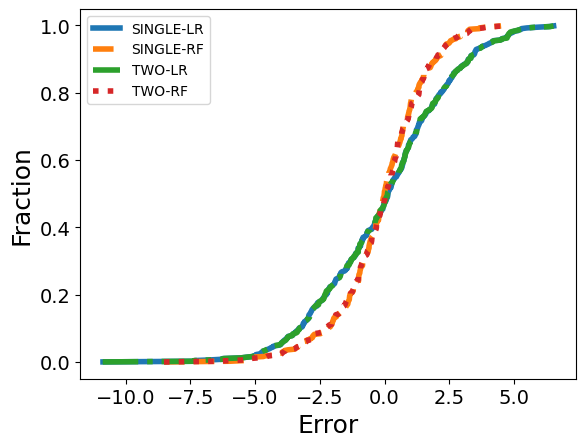

In [32]:
_metrics = 'error'
completed_df = sum_df[sum_df["state"] == "COMPLETED"]

lr_single_e = evaluate_single_model(lr_single_stage_elapsed_model, lr_single_stage_features, 'elapsed_sec', completed_df, _metrics)
rf_single_e = evaluate_single_model(rf_single_stage_elapsed_model, rf_single_stage_features, 'elapsed_sec', completed_df, _metrics)
lr_two_e = evaluate_two_stage_model(lr_first_stage_models, lr_second_stage_elapsed_model, lr_second_stage_features, 'elapsed_sec', completed_df, _metrics)
rf_two_e = evaluate_two_stage_model(rf_first_stage_models, rf_second_stage_elapsed_model, rf_second_stage_features, 'elapsed_sec', completed_df, _metrics)


sorted_lr_single_e = np.sort(lr_single_e)
frac_lr_single_e = np.arange(len(lr_single_e)) / len(lr_single_e)

sorted_rf_single_e = np.sort(rf_single_e)
frac_rf_single_e = np.arange(len(rf_single_e)) / len(rf_single_e)

sorted_lr_two_e = np.sort(lr_two_e)
frac_lr_two_e = np.arange(len(lr_two_e)) / len(lr_two_e)

sorted_rf_two_e = np.sort(rf_two_e)
frac_rf_two_e = np.arange(len(rf_two_ae)) / len(rf_two_e)

plt.plot(sorted_lr_single_e, frac_lr_single_e, '-', label='SINGLE-LR', linewidth=4)
plt.plot(sorted_rf_single_e, frac_rf_single_e, '--', label='SINGLE-RF', linewidth=4)
plt.plot(sorted_lr_two_e, frac_lr_two_e, '-.', label='TWO-LR', linewidth=4)
plt.plot(sorted_rf_two_e, frac_rf_two_e, ':', label='TWO-RF', linewidth=4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Error', fontsize=18)
plt.ylabel('Fraction', fontsize=18)
plt.legend()

# train_data, test_data = split_train_test(df, 0.25)



# # X_train = train_data[lr_single_stage_features].values
# # y_train = train_data['elapsed_sec'].values
# X_test = test_data[lr_single_stage_features].values
# y_test = test_data['elapsed_sec'].values
# y_pred = lr_single_stage_elapsed_model.predict(X_test)
# lr_single_ae = absolute_error(y_test, y_pred)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2.0332215586838194
1.299955073032685
2.02997265625
1.315069549010508


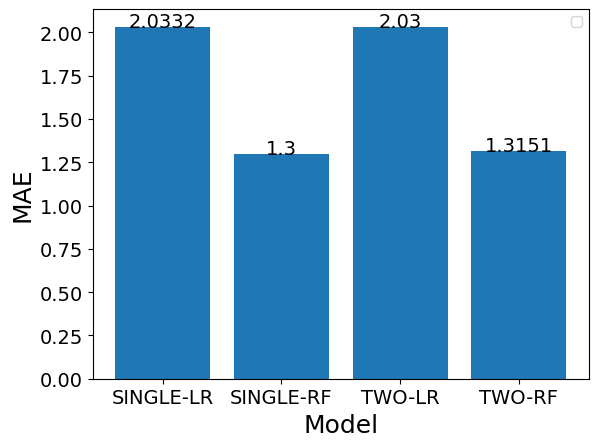

In [33]:
x = ['SINGLE-LR', 'SINGLE-RF', 'TWO-LR', 'TWO-RF']
y = [np.mean(lr_single_ae), 
     np.mean(rf_single_ae),
    np.mean(lr_two_ae),
    np.mean(rf_two_ae)]

for i in range(len(y)):
    plt.text(i, y[i], np.round(y[i],4),ha="center", fontsize=14)
    print(y[i])
plt.bar(x, y)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Model', fontsize=18)
plt.ylabel('MAE', fontsize=18)
plt.legend()